In [29]:
import networkx as nx 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import pandas as pd
import gc

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate
from gsnn.optim.EarlyStopper import EarlyStopper

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

# Training and comparison to baselines on a simple task

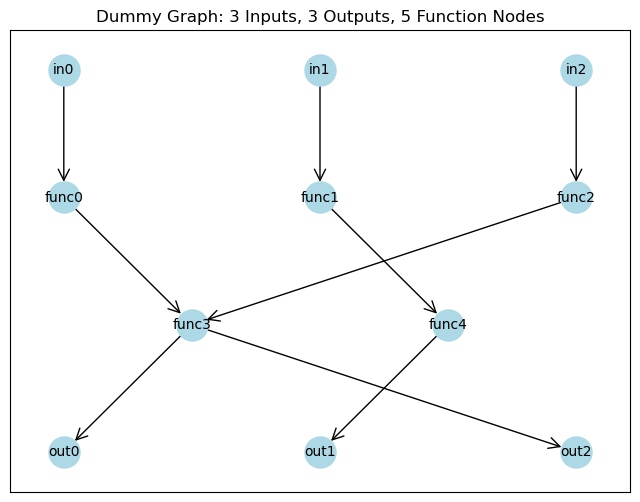

In [30]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [31]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

In [32]:
x_train, x_test, y_train, y_test = simulate(G, n_train=100, n_test=500, input_nodes=input_nodes, output_nodes=output_nodes, noise_scale=0.1,
                                            special_functions={'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                                                               'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)})

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)

In [ ]:
def train(model, model_params, train_params, x_train, y_train, x_test, y_test, device, max_epochs=500, patience=10): 

    gc.collect() 
    torch.cuda.empty_cache()

    model = model(**model_params).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    crit = torch.nn.MSELoss()

    early_stopper = EarlyStopper(patience=patience, min_delta=1e-3)

    losses = []
    for i in range(max_epochs): 
        model.train()
        optim.zero_grad() 
        yhat = model(x_train)
        loss = crit(y_train, yhat)
        loss.backward() 
        optim.step()

        with torch.no_grad(): 
            model.eval()
            loss = crit(model(x_test), y_test)
            losses.append(loss.item())
            if early_stopper.early_stop(loss): break

    del model; del optim; del crit 

    return losses

def run_search(model, model_params, training_params, x_train, y_train, x_test, y_test, device, iters=10):

    res = {**{k:[] for k in model_params.keys() if k not in ['edge_index_dict', 'node_names_dict']}, **{k:[] for k in training_params.keys()}}
    losses = []
    for i in range(iters): 
        print(f'progress: {i}/{iters}', end='\r')
        
        mp = {k:np.random.choice(model_params[k], size=1).item() for k,v in model_params.items()}
        tp = {k:np.random.choice(training_params[k], size=1).item() for k,v in training_params.items()}
        losses.append( train(model, mp, tp, x_train, y_train, x_test, y_test, device) )

        _=[res[k].append(v) for k,v in mp.items() if k not in ['edge_index_dict', 'node_names_dict']] 
        _=[res[k].append(v) for k,v in tp.items()]

    res = pd.DataFrame(res)
    return res, losses

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
iters = 100

gsnn_search_space = {'channels':np.arange(2, 20).tolist(), 
                'layers':[1,2,3,4,5,6],
                'share_layers':[True, False], 
                'add_function_self_edges':[True, False],
                'norm':['none', 'layer', 'batch', 'softmax'],
                'init':['xavier', 'kaiming'],
                'bias':[True, False], 
                'dropout':[0, 0.1],
                'residual':[True, False]}

gsnn_training_params = {'lr': [1e-1, 1e-2, 1e-3], 
                        'max_epochs':[250], 
                        'device':[device], 
                        'weight_decay':[0, 1e-2, 1e-4, 1e-6]} 

In [36]:
# GSNN with true graph structure

model_params = {**{'edge_index_dict':[data.edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn, test_losses_gsnn = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn = res_gsnn.assign(last_loss=[x[-1] for x in test_losses_gsnn], 
                            best_loss=[min(x) for x in test_losses_gsnn]) 


In [37]:
# choose random edges from GSNN graph structure

edge_index_dict = copy.deepcopy(data.edge_index_dict)
E = edge_index_dict['function', 'to', 'function'].size(1)
edge_index_dict['function', 'to', 'function']  = torch.randint(low=0, high=len(function_nodes), size=(2,E))

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_rand, test_losses_gsnn_rand = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_rand = res_gsnn_rand.assign(last_loss=[x[-1] for x in test_losses_gsnn_rand], 
                            best_loss=[min(x) for x in test_losses_gsnn_rand]) 



In [38]:
# Fully connected GSNN (all nodes connected to each other)

edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.stack((torch.arange(len(function_nodes)).repeat_interleave(len(function_nodes)), 
                                                              torch.arange(len(function_nodes)).repeat(len(function_nodes))), dim=0)

model_params = {**{'edge_index_dict':[edge_index_dict], 
                'node_names_dict':[data.node_names_dict]}, 
                **gsnn_search_space}

res_gsnn_full, test_losses_gsnn_full = run_search(GSNN, model_params, gsnn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

res_gsnn_full = res_gsnn_full.assign(last_loss=[x[-1] for x in test_losses_gsnn_full], 
                            best_loss=[min(x) for x in test_losses_gsnn_full]) 


In [39]:
nn_model_params = {'in_channels':[x_train.size(1)], 
                'out_channels':[y_train.size(1)], 
                'hidden_channels':[10,20,40,80,120], 
                'layers':[1,2],
                'norm':[torch.nn.BatchNorm1d, None],
                'dropout':[0, 0.1, 0.25]}

nn_training_params = {'lr': [1e-2, 1e-3], 
                      'max_epochs':[250], 
                        'device':[device], 
                        'weight_decay':[0, 1e-3, 1e-5]} 

res_nn, losses_nn = run_search(NN, nn_model_params, nn_training_params, x_train, y_train, x_test, y_test, device, iters=iters)

In [40]:
print(f'best test loss NN: {min([min(loss) for loss in losses_nn])}')
print(f'best test loss GSNN: {min([min(loss) for loss in test_losses_gsnn])}')
print(f'best test loss GSNN (rand graph): {min([min(loss) for loss in test_losses_gsnn_rand])}')
print(f'best test loss GSNN (fully connected): {min([min(loss) for loss in test_losses_gsnn_full])}')

best test loss NN: 0.15794168412685394
best test loss GSNN: 0.11244667321443558
best test loss GSNN (rand graph): 1.0858142375946045
best test loss GSNN (fully connected): 0.14685940742492676


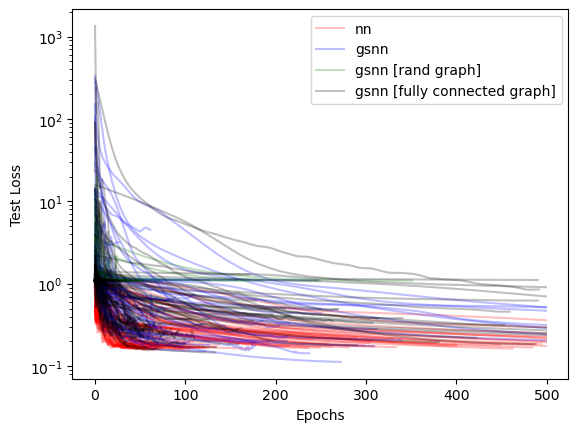

In [58]:
alpha = 0.25

plt.figure()

for i, loss in enumerate(losses_nn): 
    if i == 0: 
        plt.plot(loss, 'r-', label='nn', alpha=alpha)
    else:
        plt.plot(loss, 'r-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn):
    if i == 0: 
        plt.plot(loss, 'b-', label='gsnn', alpha=alpha)
    else:
        plt.plot(loss, 'b-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_rand):
    if i == 0: 
        plt.plot(loss, 'g-', label='gsnn [rand graph]', alpha=alpha)
    else:
        plt.plot(loss, 'g-', alpha=alpha)

for i, loss in enumerate(test_losses_gsnn_full):
    if i == 0: 
        plt.plot(loss, 'k-', label='gsnn [fully connected graph]', alpha=alpha)
    else:
        plt.plot(loss, 'k-', alpha=alpha)

plt.xlabel('Epochs')
plt.ylabel('Test Loss')

#plt.ylim(0.,1.5)
plt.legend()
plt.yscale('log')
plt.show()

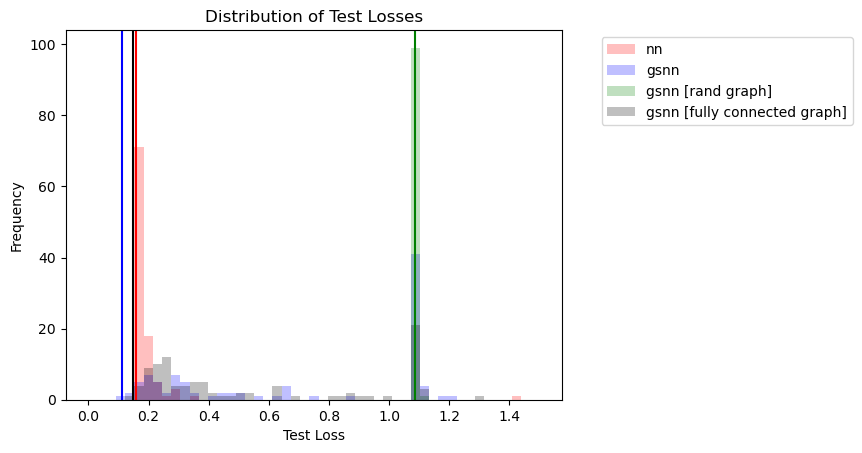

In [42]:
bins = np.linspace(0.,1.5,50)

plt.figure()
plt.hist([min(loss) for loss in losses_nn], label='nn', alpha=0.25, color='r', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn], label='gsnn', alpha=0.25, color='b', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_rand], label='gsnn [rand graph]', alpha=0.25, color='g', bins=bins)
plt.hist([min(loss) for loss in test_losses_gsnn_full], label='gsnn [fully connected graph]', alpha=0.25, color='k', bins=bins)

plt.axvline(np.nanmin([min(loss) for loss in losses_nn]),  color='r')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn]),  color='b')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_rand]),  color='g')
plt.axvline(np.nanmin([min(loss) for loss in test_losses_gsnn_full]), color='k')

plt.xlabel('Test Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Test Losses')

# place legend outside 
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))

plt.show()

In [43]:
# best gsnn hyper params 
res_gsnn.sort_values(by='best_loss', ascending=True).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,init,bias,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
62,17,5,False,False,none,kaiming,True,0.0,True,0.10,250,cuda,0.000100,0.112447,0.112447
91,7,5,True,True,none,xavier,False,0.0,False,0.01,250,cuda,0.000001,0.143544,0.142536
70,15,2,True,False,none,xavier,True,0.0,False,0.01,250,cuda,0.000000,0.151221,0.151221
7,11,4,False,True,layer,xavier,True,0.0,False,0.01,250,cuda,0.000001,0.176988,0.154859
76,14,3,True,True,batch,xavier,False,0.0,True,0.10,250,cuda,0.000100,0.175654,0.175407
93,10,3,True,False,softmax,kaiming,True,0.0,True,0.01,250,cuda,0.000000,0.175637,0.175637
2,18,3,False,False,softmax,xavier,False,0.1,True,0.10,250,cuda,0.000100,0.189849,0.176252
98,14,6,False,True,layer,xavier,True,0.0,True,0.01,250,cuda,0.000100,0.180157,0.180157
58,10,3,False,True,batch,kaiming,False,0.1,True,0.01,250,cuda,0.000001,0.197417,0.187045
8,7,5,False,False,none,xavier,False,0.0,True,0.01,250,cuda,0.000000,0.195236,0.194162


In [44]:
res_gsnn.sort_values(by='best_loss', ascending=False).head(10)

,channels,layers,share_layers,add_function_self_edges,norm,init,bias,dropout,residual,lr,max_epochs,device,weight_decay,last_loss,best_loss
86,16,5,True,False,layer,kaiming,False,0.0,True,0.001,250,cuda,0.0100,4.512694,4.338974
31,9,6,False,True,batch,kaiming,False,0.0,True,0.001,250,cuda,0.0001,3.207670,2.959182
73,3,6,False,False,batch,kaiming,True,0.0,False,0.100,250,cuda,0.0000,4.722194,1.197576
18,8,5,True,True,batch,xavier,True,0.1,False,0.001,250,cuda,0.0100,1.243888,1.164365
15,14,5,True,True,batch,xavier,False,0.0,True,0.010,250,cuda,0.0001,1.793731,1.109024
22,13,1,False,False,softmax,kaiming,False,0.0,False,0.001,250,cuda,0.0100,1.106262,1.106262
85,16,1,True,False,batch,kaiming,True,0.1,True,0.100,250,cuda,0.0000,1.251631,1.105446
95,3,3,True,False,softmax,kaiming,True,0.0,False,0.001,250,cuda,0.0100,1.104879,1.104879
32,4,1,True,False,softmax,kaiming,False,0.1,True,0.001,250,cuda,0.0001,1.101285,1.101285
39,11,3,True,False,layer,kaiming,True,0.0,False,0.001,250,cuda,0.0100,1.116931,1.098958


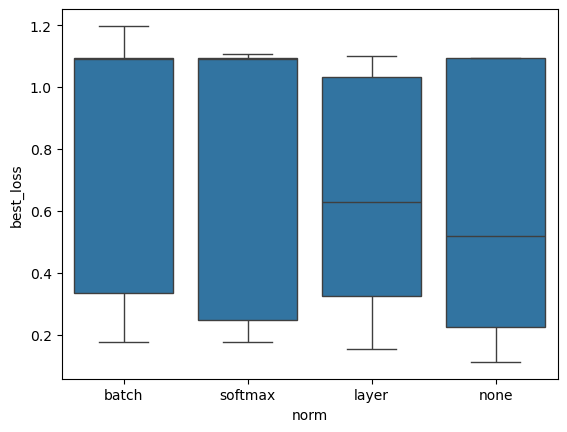

In [45]:
plt.figure()
sbn.boxplot(x='norm', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

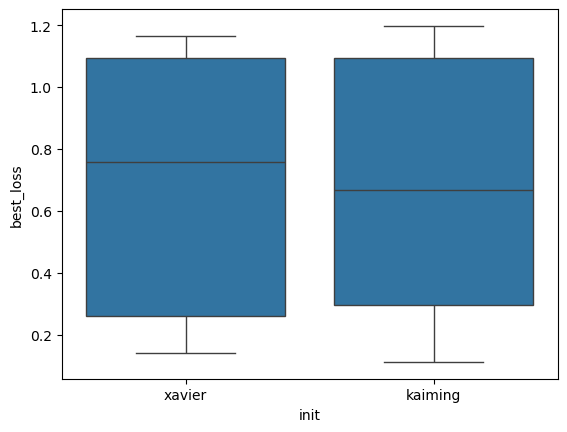

In [46]:
plt.figure() 
sbn.boxplot(x='init', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show()

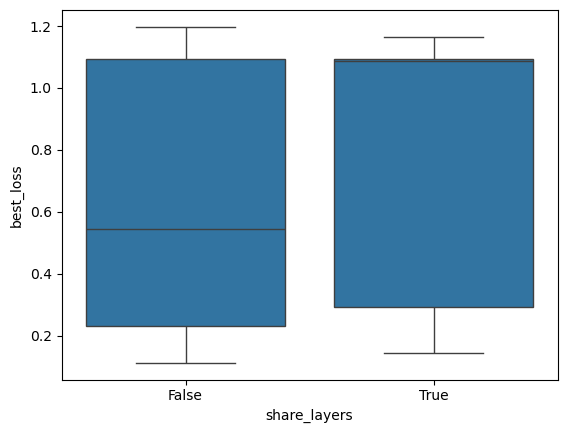

In [47]:
plt.figure() 
sbn.boxplot(x='share_layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

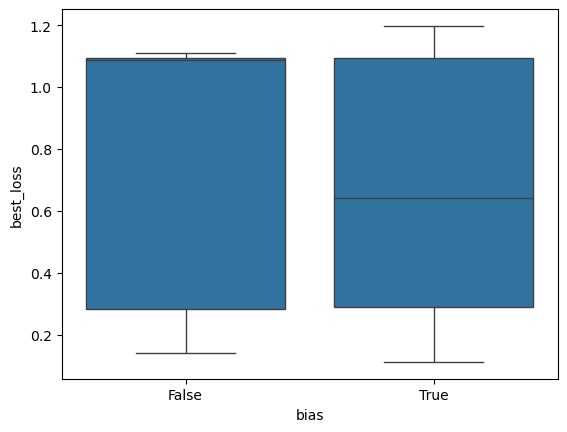

In [48]:
plt.figure() 
sbn.boxplot(x='bias', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

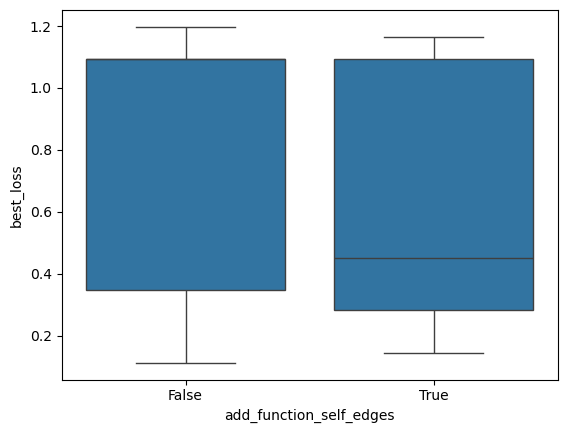

In [49]:
plt.figure() 
sbn.boxplot(x='add_function_self_edges', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

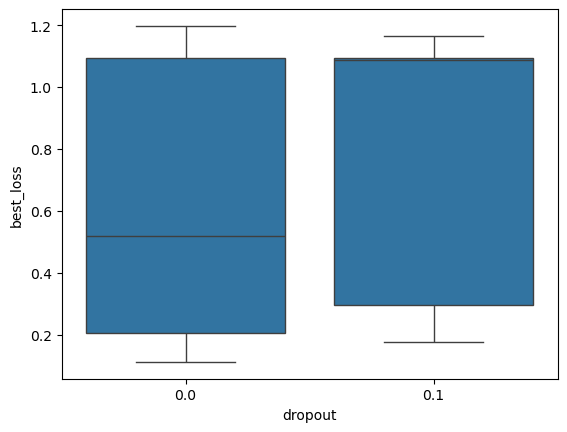

In [50]:
plt.figure() 
sbn.boxplot(x='dropout', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

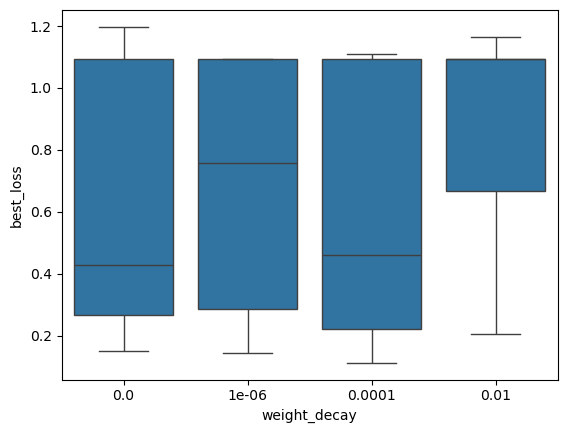

In [51]:
plt.figure() 
sbn.boxplot(x='weight_decay', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

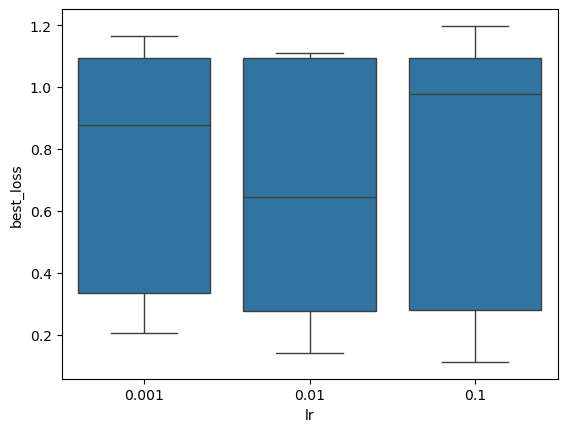

In [52]:
plt.figure() 
sbn.boxplot(x='lr', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

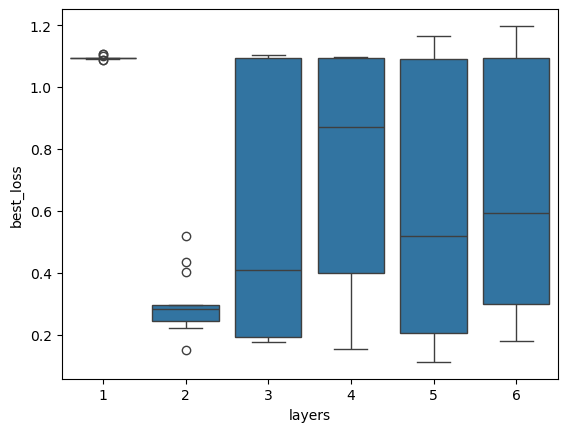

In [53]:
plt.figure() 
sbn.boxplot(x='layers', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 

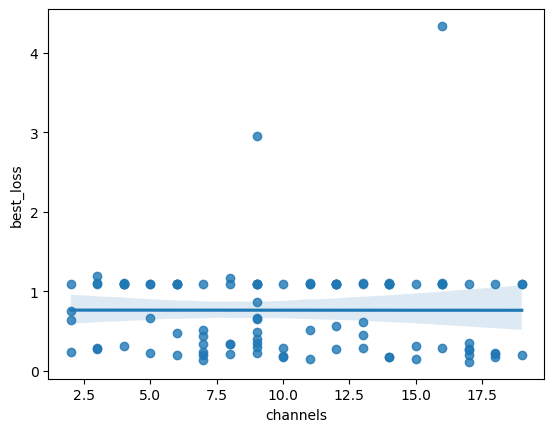

In [59]:
plt.figure() 
sbn.regplot(x='channels', y='best_loss', data=res_gsnn)
plt.show() 

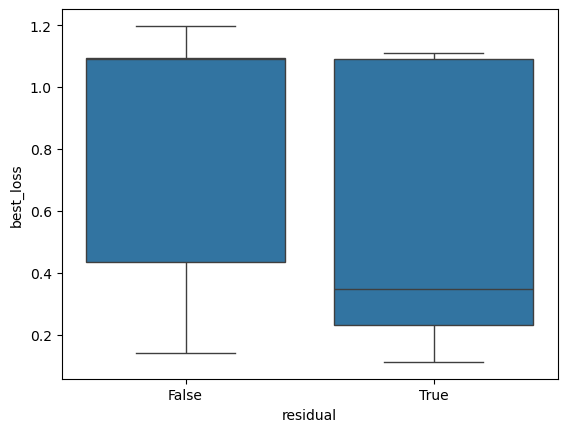

In [60]:
plt.figure() 
sbn.boxplot(x='residual', y='best_loss', data=res_gsnn[lambda x: x.best_loss < 1.5])
plt.show() 